## Hourly Time Series Forecasting with XGBoost

In [269]:
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from meteostat import Stations, Hourly
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


plt.style.use('fivethirtyeight')

## Data


In [270]:
# --- load & preprocess as before ---
pjme = (
    pd.read_csv(
        '../data/3/PJME_hourly.csv',
        index_col=0,
        parse_dates=[0]
    )
    .sort_index()                            # ← sort first
    .loc['2003-01-01':'2018-08-02']          # now slicing works
)

# --- build the “extended” holiday list ---
cal       = USFederalHolidayCalendar()
# get all observed federal holidays in the date‐range
fed_hols  = cal.holidays(start=pjme.index.min(), end=pjme.index.max())
extended  = set(fed_hols)  # start with the observed dates

# now add bridge days specifically for July 4th
for year in range(pjme.index.year.min(), pjme.index.year.max()+1):
    july4 = datetime(year, 7, 4)

    wd = july4.weekday()
    if wd == 1:   # Tuesday
        extended.add(july4 - timedelta(days=1))  # add Monday
    elif wd == 2: # Wednesday
        extended.add(july4 + timedelta(days=1))  # Thursday
        extended.add(july4 + timedelta(days=2))  # Friday
    elif wd == 3: # Thursday
        extended.add(july4 + timedelta(days=1))  # Friday

# turn it back into a sorted DatetimeIndex
all_hols = pd.DatetimeIndex(sorted(extended))

# --- flag in your DF ---
pjme['is_holiday'] = pjme.index.normalize().isin(all_hols)
pjme['is_weekend'] = pjme.index.weekday >= 5

# calendar features
pjme['hour']       = pjme.index.hour
pjme['dayofweek']  = pjme.index.weekday
pjme['quarter']    = pjme.index.quarter
pjme['month']      = pjme.index.month
pjme['year']       = pjme.index.year
pjme['dayofyear']  = pjme.index.dayofyear
pjme['dayofmonth'] = pjme.index.day
pjme['weekofyear'] = pjme.index.isocalendar().week.astype(int)

# create the combined flag
pjme['is_dayoff'] = pjme['is_holiday'] | pjme['is_weekend']

# drop the originals
pjme.drop(columns=['is_holiday', 'is_weekend'], inplace=True)

print('Monotonic?', pjme.index.is_monotonic_increasing)

print(pjme.shape)
pjme.head()

Monotonic? True
(136608, 10)


,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_dayoff
Datetime,,,,,,,,,,
2003-01-01 00:00:00,27008.0,0,2,1,1,2003,1,1,1,True
2003-01-01 01:00:00,25591.0,1,2,1,1,2003,1,1,1,True
2003-01-01 02:00:00,24235.0,2,2,1,1,2003,1,1,1,True
2003-01-01 03:00:00,23121.0,3,2,1,1,2003,1,1,1,True
2003-01-01 04:00:00,22445.0,4,2,1,1,2003,1,1,1,True


## Adding weather

In [271]:
# 1) Define your time‐range
start = datetime(2002, 12, 31)
end   = datetime(2018, 8, 4)
target_icaos = ['KPHL', 'KEWR', 'KBWI', 'KDCA'] # List of desired ICAO codes

# 2) Find stations near Philadelphia and check inventory
stations_query = Stations()
stations_query = stations_query.nearby(39.95, -75.17)
stations_query = stations_query.inventory('hourly', (start, end))

# 3) Fetch ALL stations that meet the criteria into a DataFrame
all_stations_df = stations_query.fetch() # <-- Fetch all results
target_stations_df = all_stations_df[all_stations_df['icao'].isin(target_icaos)]

# get the WMO-IDs (the DataFrame’s index)
station_ids = target_stations_df.index.tolist()

# fetch hourly data for _all_ stations in one call
weather_all = Hourly(station_ids, start, end).fetch()

weather_all.head()

temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt  \
station time                                                                   
72408   2002-12-31 00:00:00   5.0  -1.0  65.0   0.0   NaN  140.0  11.2   NaN   
        2002-12-31 01:00:00   5.0  -0.6  67.0   0.0   NaN  130.0   7.6   NaN   
        2002-12-31 02:00:00   4.4   0.0  73.0   0.0   NaN   90.0   9.4   NaN   
        2002-12-31 03:00:00   5.0   0.6  73.0   0.0   NaN   90.0   7.6   NaN   
        2002-12-31 04:00:00   5.0   1.7  79.0   NaN   NaN   60.0   5.4   NaN   

                               pres  tsun  coco  
station time                                     
72408   2002-12-31 00:00:00  1025.1   NaN   NaN  
        2002-12-31 01:00:00  1024.7   NaN   NaN  
        2002-12-31 02:00:00  1023.8   NaN   NaN  
        2002-12-31 03:00:00  1023.3   NaN   NaN  
        2002-12-31 04:00:00  1022.9   NaN   NaN

In [272]:
average_data = (
    weather_all
    .groupby(level='time')
    .mean()
    [['temp', 'dwpt', 'rhum', 'prcp', 'wspd']]
    .sort_index()                            # ← sort first
    .loc['2003-01-01':'2018-08-02']          # now slicing works
)
# Check missing values
print(average_data.isnull().sum())
print(average_data.shape)

average_data.tail()

temp      0
dwpt      0
rhum      0
prcp    407
wspd      1
dtype: int64
(136632, 5)


,temp,dwpt,rhum,prcp,wspd
time,,,,,
2018-08-02 19:00:00,28.500,22.000,68.75,0.066667,18.100
2018-08-02 20:00:00,27.625,22.525,75.75,0.933333,17.100
2018-08-02 21:00:00,27.375,22.100,75.00,1.100000,13.850
2018-08-02 22:00:00,27.375,22.175,75.00,0.250000,11.525
2018-08-02 23:00:00,26.400,22.450,80.00,1.366667,12.100


In [273]:
# combine the dfs
pjme_weather = (
    pjme
    .join(average_data, how='left')
    .dropna()
)
# check for missing values
print(pjme_weather.isnull().sum())
print(pjme_weather.shape)
pjme_weather.tail()

# --- drop the original target variable ---

PJME_MW       0
hour          0
dayofweek     0
quarter       0
month         0
year          0
dayofyear     0
dayofmonth    0
weekofyear    0
is_dayoff     0
temp          0
dwpt          0
rhum          0
prcp          0
wspd          0
dtype: int64
(136200, 15)


,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_dayoff,temp,dwpt,rhum,prcp,wspd
2018-08-02 19:00:00,45641.0,19,3,3,8,2018,214,2,31,False,28.500,22.000,68.75,0.066667,18.100
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,False,27.625,22.525,75.75,0.933333,17.100
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,False,27.375,22.100,75.00,1.100000,13.850
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,False,27.375,22.175,75.00,0.250000,11.525
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,False,26.400,22.450,80.00,1.366667,12.100


In [280]:
# 1) Split off the final 20% as the true test set
train_val_df, test_df = train_test_split(
    pjme_weather,
    test_size=0.1,
    shuffle=False              # preserve chronological order
)

# 2) Of the remaining 80%, split 25% of that (i.e. 20% of total) as validation
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,
    shuffle=False
)

# 3) Check proportions
total = len(pjme_weather)
print(f"Train: {len(train_df)} rows  ({len(train_df)/total:.0%})")
print(f"Val  : {len(val_df)} rows  ({len(val_df)/total:.0%})")
print(f"Test : {len(test_df)} rows  ({len(test_df)/total:.0%})")


Train: 98064 rows  (72%)
Val  : 24516 rows  (18%)
Test : 13620 rows  (10%)


In [281]:
# Make sure the original is sorted
print("Original sorted?    ", pjme.index.is_monotonic_increasing)

# Boundary of the split
print("Train-val ends at: ", train_val_df.index[-1])
print("Test   starts at:  ", test_df.index[0])

# Confirm no overlap
assert train_val_df.index[-1] < test_df.index[0]

# And make sure each piece is still time-ordered
print("Train-val sorted?  ", train_val_df.index.is_monotonic_increasing)
print("Test   sorted?     ", test_df.index.is_monotonic_increasing)


Original sorted?     True
Train-val ends at:  2017-01-10 13:00:00
Test   starts at:   2017-01-10 14:00:00
Train-val sorted?   True
Test   sorted?      True


# Create Time Series Features

In [282]:
def create_Xy(df: pd.DataFrame, label: str) -> tuple[pd.DataFrame, pd.Series]:
    """
    Split a DataFrame into feature matrix X and target vector y.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing all predictor columns plus the target column.
    label : str
        Name of the target column in df.
    
    Returns
    -------
    X : pd.DataFrame
        All columns except `label`.
    y : pd.Series
        The `label` column.
    """
    if label not in df.columns:
        raise KeyError(f"Label column '{label}' not found in DataFrame")

    df_copy = df.copy()
    y       = df_copy.pop(label)
    X       = df_copy
    return X, y

In [283]:
X_train, y_train = create_Xy(train_df, label='PJME_MW')
X_val, y_val = create_Xy(val_df, label='PJME_MW')
X_test, y_test = create_Xy(test_df, label='PJME_MW')

In [284]:
# 1) Instantiate the regressor:
reg = xgb.XGBRegressor(
    n_estimators=1000,            # up to 1,000 trees
    early_stopping_rounds=50      # stop if no improvement in 50 rounds
)

# 2) Fit with train + validation sets
reg.fit(
    X_train,                      # features for the first 72% of data
    y_train,                      # targets for the first 72%
    eval_set=[                    # evaluation folds for early-stopping
        (X_train, y_train),       #   validation_0 = training RMSE
        (X_val,   y_val)          #   validation_1 = validation RMSE
    ],
    verbose=False                 # turn off per-iteration logging
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

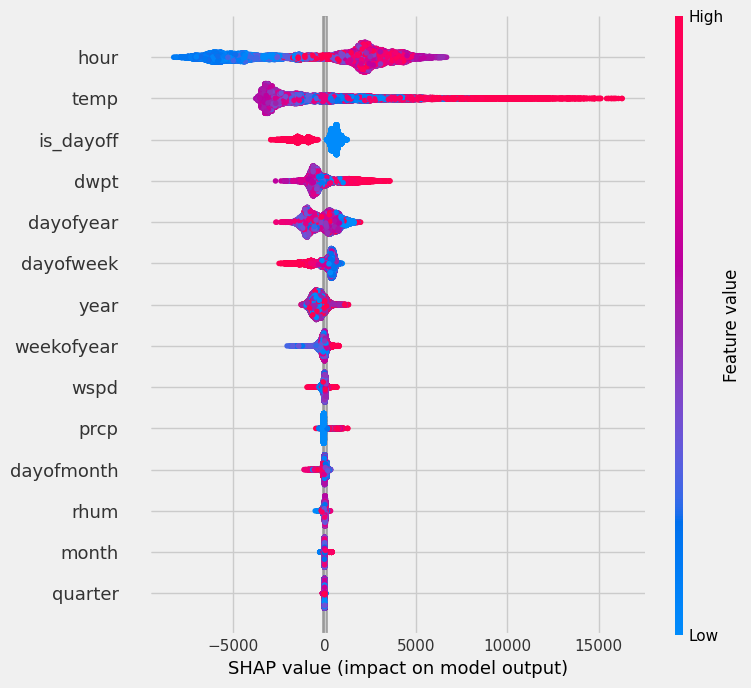

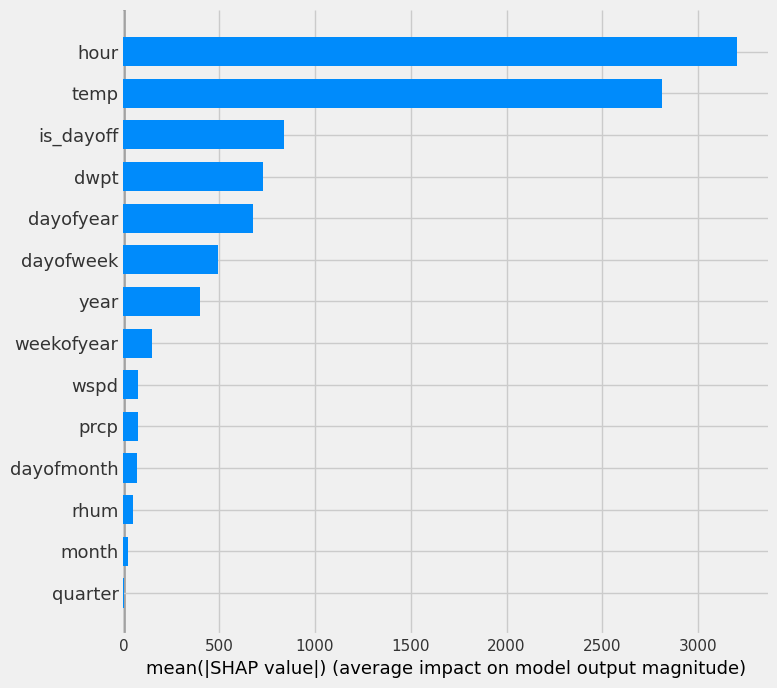

In [285]:
# 1. Create a TreeExplainer for your fitted model
explainer = shap.TreeExplainer(reg)

# 2. Compute SHAP values on a background dataset (e.g. your validation set)
shap_values = explainer.shap_values(X_val)

# 3. Plot the familiar “beeswarm” summary plot
shap.summary_plot(shap_values, X_val, feature_names=X_val.columns)

# — or if you just want a bar‐style importance ranking — 
shap.summary_plot(shap_values, X_val, feature_names=X_val.columns, plot_type="bar")

# Forecast on Test Set

<Axes: >

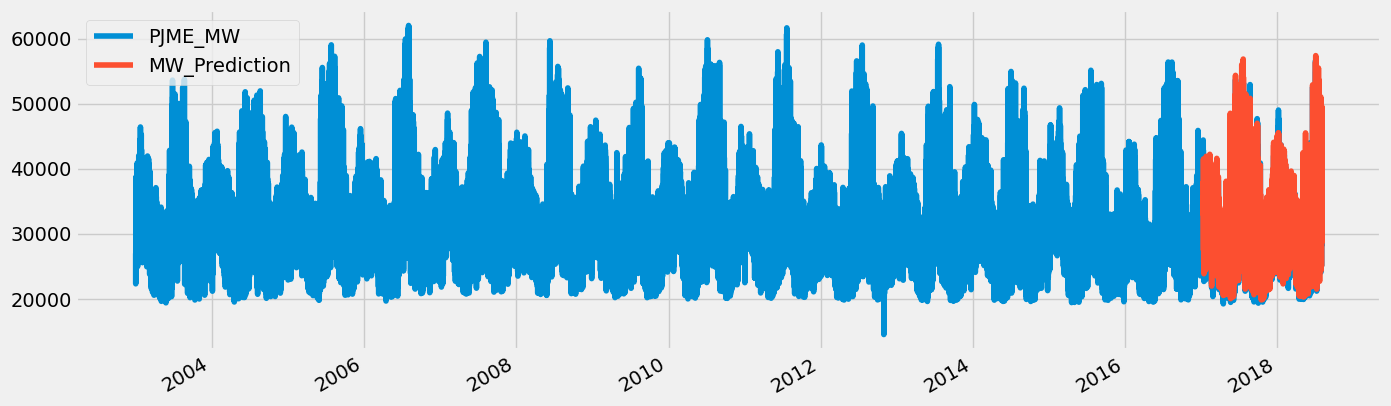

In [286]:
test_df['MW_Prediction'] = reg.predict(X_test)
all_df = pd.concat([train_val_df, test_df])
all_df[['PJME_MW','MW_Prediction']].sort_index().plot(figsize=(15,5))

# Look at first month of predictions

In [287]:
test_df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_dayoff,temp,dwpt,rhum,prcp,wspd,MW_Prediction
2017-01-10 14:00:00,38729.0,14,1,1,1,2017,10,10,2,False,-4.575,-10.00,66.00,0.0,7.85,38133.945312
2017-01-10 15:00:00,38450.0,15,1,1,1,2017,10,10,2,False,-2.800,-9.80,59.00,0.0,10.30,37452.492188
2017-01-10 16:00:00,38484.0,16,1,1,1,2017,10,10,2,False,-1.675,-9.85,53.75,0.0,11.10,37281.804688
2017-01-10 17:00:00,39435.0,17,1,1,1,2017,10,10,2,False,-0.825,-10.00,50.00,0.0,12.10,38174.707031
2017-01-10 18:00:00,41298.0,18,1,1,1,2017,10,10,2,False,0.425,-9.20,48.75,0.0,13.90,41225.542969


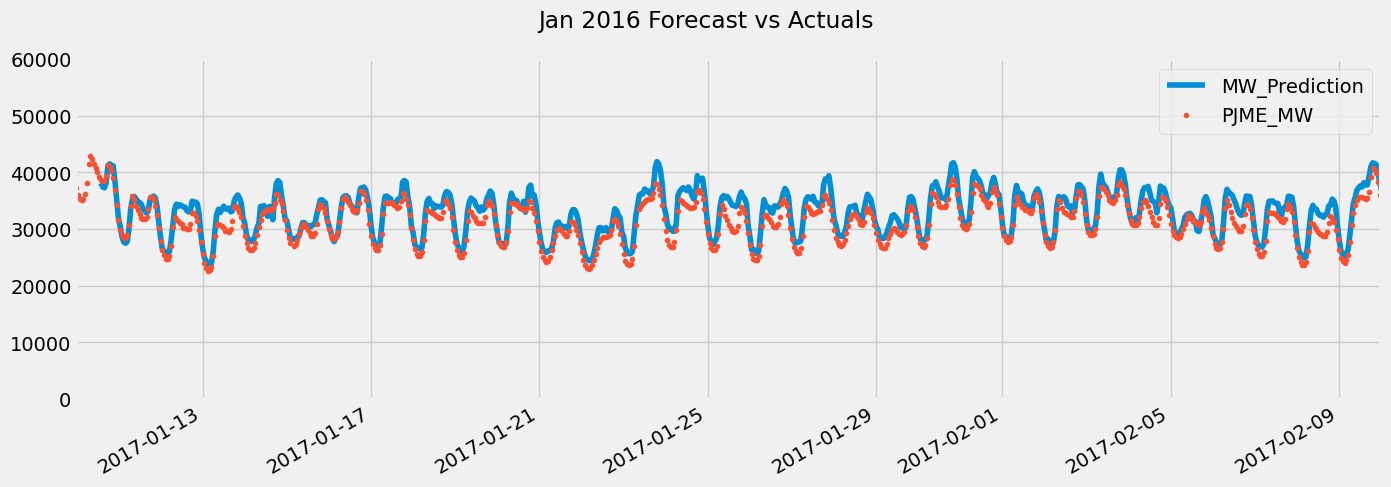

In [288]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = all_df[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-10-2017', upper='02-10-2017')
ax.set_ylim(0, 60000)
plot = plt.suptitle('Jan 2016 Forecast vs Actuals')

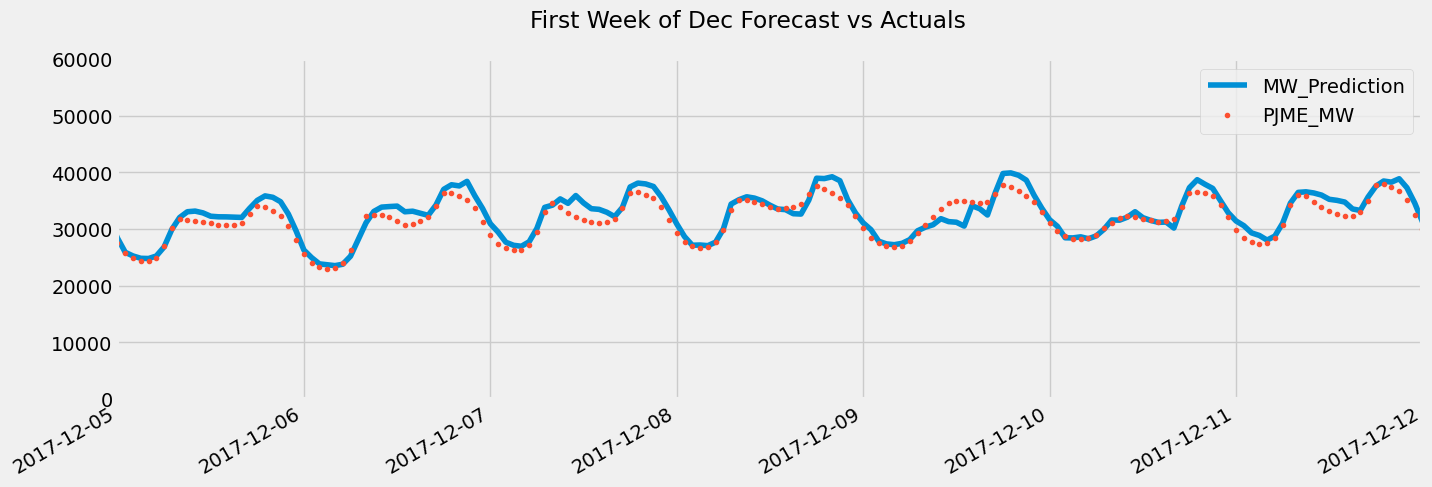

In [289]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = all_df[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='12-05-2017', upper='12-12-2017')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of Dec Forecast vs Actuals')

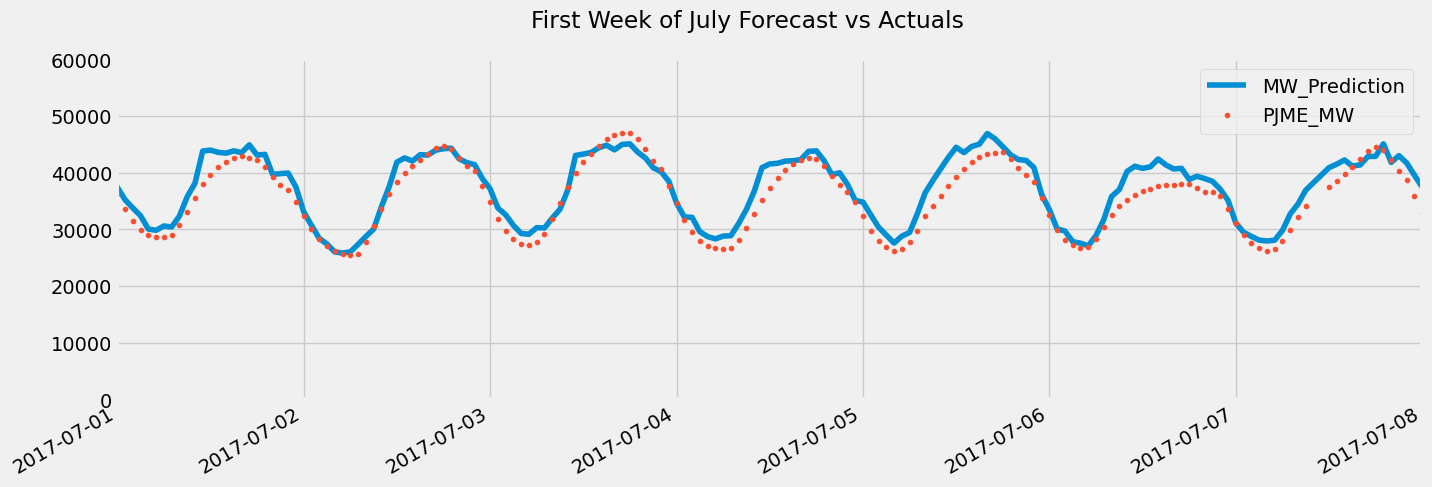

In [290]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = all_df[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2017', upper='07-08-2017')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

## Test‐Set Error Metrics

After training on the first 72 % of our timeline and validating on the next 18 %, we hold out the final 10 % for a fully unbiased evaluation. On that test fold, we obtained:

- **Mean Squared Error (MSE):** 15,104,227 (MW²)  
- **Root Mean Squared Error (RMSE):** √15,104,227 ≈ **3,887 MW**  
- **Mean Absolute Error (MAE):** **3,045 MW**  
- **Mean Absolute Percentage Error (MAPE):** **9.7 %**

### Interpretation

- An **RMSE of ~3.9 GW** and **MAE of ~3.0 GW** tell us that typical forecast errors hover around a few gigawatts—on average, our hourly predictions miss by roughly 3 GW.  
- The **MAPE of ~9.7 %** means that, relative to actual loads, our forecasts are within 10 % on average.  
- These results reflect strong performance on “routine” days but also highlight the remaining gap on weather‐extreme or holiday periods—reinforcing the need for exogenous regressors (temperature, holiday flags) to tame those large deviations.

In [291]:
mean_squared_error(y_true=test_df['PJME_MW'],
                   y_pred=test_df['MW_Prediction'])

3270855.24212138

In [292]:
mean_absolute_error(y_true=test_df['PJME_MW'],
                   y_pred=test_df['MW_Prediction'])

1458.7092783475587

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are.
MAPE isn't included in sklearn so we need to use a custom function.

In [293]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    # 1) Convert inputs to NumPy arrays for element-wise math
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # 2) Compute the absolute percentage error for each point:
    #    |(true − pred) / true|
    errors = np.abs((y_true - y_pred) / y_true)

    # 3) Take the average of those percentages
    mean_error = np.mean(errors)

    # 4) Multiply by 100 to express as “percent”
    return mean_error * 100

In [294]:
mape = mean_absolute_percentage_error(
    y_true=test_df['PJME_MW'],
    y_pred=test_df['MW_Prediction']
)
print(f"MAPE: {mape:.2f}%")

MAPE: 4.80%


In [295]:
test_df['error'] = test_df['PJME_MW'] - test_df['MW_Prediction']
test_df['abs_error'] = test_df['error'].apply(np.abs)
error_by_day = test_df.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [296]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2017 2     25          24344.458333   28541.000000 -4196.541341  4196.541341
     12    31          39016.000000   34965.164062  4050.835124  4050.835124
2018 1     6           43565.750000   40044.933594  3520.814128  3520.814128
2017 2     24          26445.083333   29809.720703 -3364.637207  3364.637207
2018 1     7           42159.708333   38972.871094  3186.838704  3186.838704
     3     3           28436.791667   31588.398438 -3151.606527  3151.606527
2017 2     20          27070.583333   30152.498047 -3081.914469  3087.312093
     3     2           28309.083333   31384.869141 -3075.787354  3075.787354
2018 5     2           28349.666667   31385.876953 -3036.210124  3036.210124
2017 9     4           26552.416667   29577.029297 -3024.612467  3024.612467

In [297]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2018 2     6           35783.833333   36069.863281 -286.028809  325.659505
2017 3     25          25639.875000   25626.603516   13.270426  356.742432
           31          30181.041667   30559.468750 -378.427327  378.427327
2018 1     16          36168.333333   35951.175781  217.156657  434.864990
2017 12    27          37027.875000   36780.410156  247.464437  438.891195
2018 3     25          28642.375000   28552.421875   89.952881  459.835693
2017 4     7           28840.250000   29139.640625 -299.390381  477.813070
     12    17          31386.750000   31344.859375   41.889567  480.893473
2018 3     28          30032.833333   30143.576172 -110.741943  491.280029
2017 3     28          28118.666667   28474.281250 -355.613525  498.654378

# Plotting some best/worst predicted days

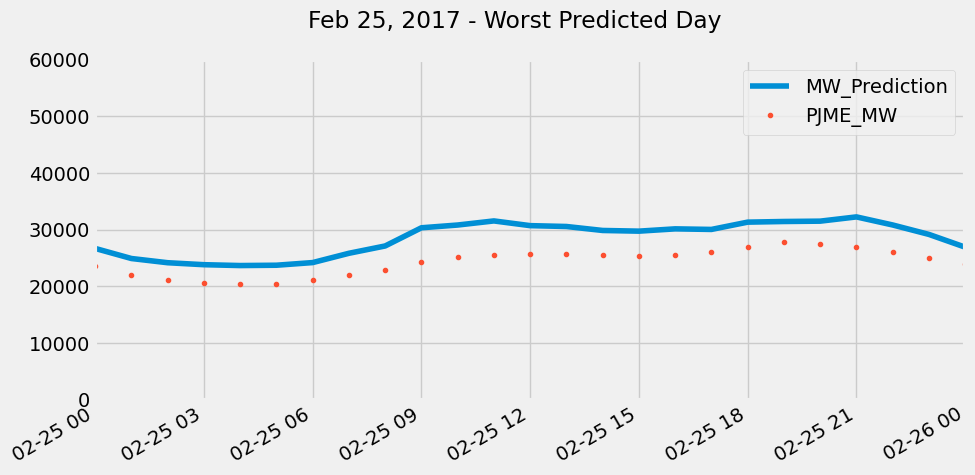

In [301]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = all_df[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='02-25-2017', upper='02-26-2017')
plot = plt.suptitle('Feb 25, 2017 - Worst Predicted Day')

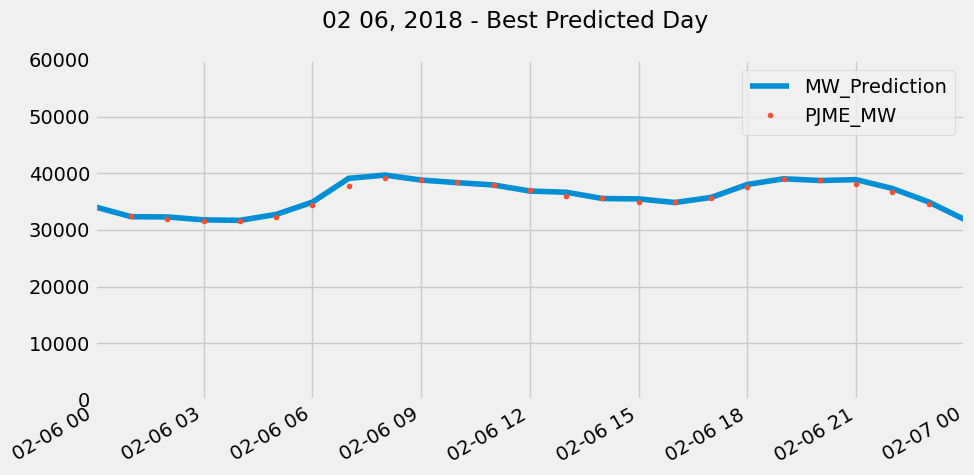

In [303]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = all_df[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='02-06-2018', upper='02-07-2018')
plot = plt.suptitle('02 06, 2018 - Best Predicted Day')